In [ ]:
cd /content/drive/MyDrive/fnd-sample-1/classification_news_model/model-pipeline

/content/drive/MyDrive/fnd-sample-1/classification_news_model/model-pipeline


In [ ]:
ls

fine_tuned_xlm_roberta_news/  news_sinhala_cleaned.csv  wandb/
model_creation.ipynb          results/


In [ ]:
import pandas as pd

# Upload your CSV to Colab or use files.upload()
df = pd.read_csv("/content/drive/MyDrive/fnd-sample-1/classification_news_model/model-pipeline/news_sinhala_cleaned.csv")  # or 'large' version
print(df.head(10))

                                               title               category  \
0  ඩිජිටල් රහස්යතා රෙගුලාසි පිළිබඳ නව පනත් කෙටුම්...  PoliticsAndGovernance   
1  අයවැය කප්පාදු මධ්යයේ පාර්ලිමේන්තුව නොමිලේ උසස්...  PoliticsAndGovernance   
2  ග්රාමීය නියෝජනය ශක්තිමත් කිරීම සඳහා ශ්රී ලංකා ...  PoliticsAndGovernance   
3  පළාත් පාලන මැතිවරණ ප්රමාදය විවේචනය කරන විපක්ෂ ...  PoliticsAndGovernance   
4  කොළඹ මහ නගර සභාව දූෂණ විරෝධී ක්ෂණික ඇමතුම් අංක...  PoliticsAndGovernance   
5  ප්රතිපත්ති සම්පාදනයේදී වැඩි කාර්යභාරයක් ඉල්ලා ...  PoliticsAndGovernance   
6  ආණ්ඩුක්රම ව්යවස්ථාවේ ආගමික නිදහස පිළිබඳ වගන්ති...  PoliticsAndGovernance   
7  ශ්රී ලංකාවේ පළමු මාර්ගගත ඡන්ද විමසීමේ නියමු වැ...  PoliticsAndGovernance   
8  නව විමධ්යගත කිරීමේ පනත යටතේ පළාත් සභා බලගැන්වී...  PoliticsAndGovernance   
9  නව බදු යෝජනාව මධ්යම ආදායම් ලබන කණ්ඩායම්වලින් ප...  PoliticsAndGovernance   

       sub category  
0  DomesticPolitics  
1  DomesticPolitics  
2  DomesticPolitics  
3  DomesticPolitics  
4  DomesticPolitics 

In [ ]:
class_counts = df['sub category'].value_counts()
print(class_counts)

sub category
CourtsAndInvestigation    629
DomesticPolitics          534
TechAndInnovation         500
InternationalPolitics     499
ResearchAndSpace          499
CrimeReport               499
ScreenAndStage            450
MusicAndArts              449
Football                  405
Cricket                   405
Other                     383
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['sub category'])

In [ ]:
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

In [ ]:
print(le.classes_)      # Shows the categories in order of their encoding
print(le.transform(le.classes_))   # Shows how each class is mapped to an integer

['CourtsAndInvestigation' 'Cricket' 'CrimeReport' 'DomesticPolitics'
 'Football' 'InternationalPolitics' 'MusicAndArts' 'Other'
 'ResearchAndSpace' 'ScreenAndStage' 'TechAndInnovation']
[ 0  1  2  3  4  5  6  7  8  9 10]


In [ ]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['title'], df['label_encoded'],
    test_size=0.1, stratify=df['label_encoded'], random_state=42
)

In [ ]:
from transformers import XLMRobertaTokenizer

tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

def tokenize(texts):
    return tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=32,
        return_tensors='pt'
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [ ]:
import torch

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

In [ ]:
len(le.classes_)

11

In [ ]:
from transformers import XLMRobertaForSequenceClassification

model = XLMRobertaForSequenceClassification.from_pretrained(
    'xlm-roberta-base',
    num_labels=len(le.classes_)
)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
pip install wandb

In [1]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:


Abort: 

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(p):  # or: def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    f1 = f1_score(p.label_ids, preds, average='macro')
    precision = precision_score(p.label_ids, preds, average='macro')
    recall = recall_score(p.label_ids, preds, average='macro')
    acc = (preds == p.label_ids).mean()
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./results",

    # core hyper-parameters
    num_train_epochs=50,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,

    # when to evaluate / save / log
    eval_strategy="epoch",        # run validation at the end of every epoch
    save_strategy="epoch",        # checkpoint once per epoch
    logging_dir='./logs',
    logging_steps=10,     # log metrics once per epoch

    # keep the best model (by validation accuracy) loaded at the end
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="wandb",   # Comment this line if not using wandb
    save_total_limit=2   # Only keep the 2 best models (saves space)
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.359000,0.963905,0.680608,0.671109,0.663474,0.658190
2,0.870400,0.741869,0.747148,0.730682,0.729442,0.711008
3,0.849100,0.619250,0.790875,0.791065,0.774884,0.760663
4,0.582600,0.649838,0.794677,0.786658,0.781633,0.778291
5,0.524500,0.617050,0.804183,0.800583,0.792888,0.791632
6,0.393500,0.652529,0.832700,0.826244,0.823846,0.822881
7,0.262300,0.633263,0.828897,0.833320,0.818337,0.818656
8,0.281300,0.679945,0.821293,0.817694,0.810528,0.809626
9,0.178500,0.810458,0.825095,0.824628,0.815712,0.816428
10,0.118200,0.859715,0.834601,0.834745,0.826717,0.826539


TrainOutput(global_step=14800, training_loss=0.14661627278488595, metrics={'train_runtime': 1327.5515, 'train_samples_per_second': 177.997, 'train_steps_per_second': 11.148, 'total_flos': 3886135401849600.0, 'train_loss': 0.14661627278488595, 'epoch': 50.0})

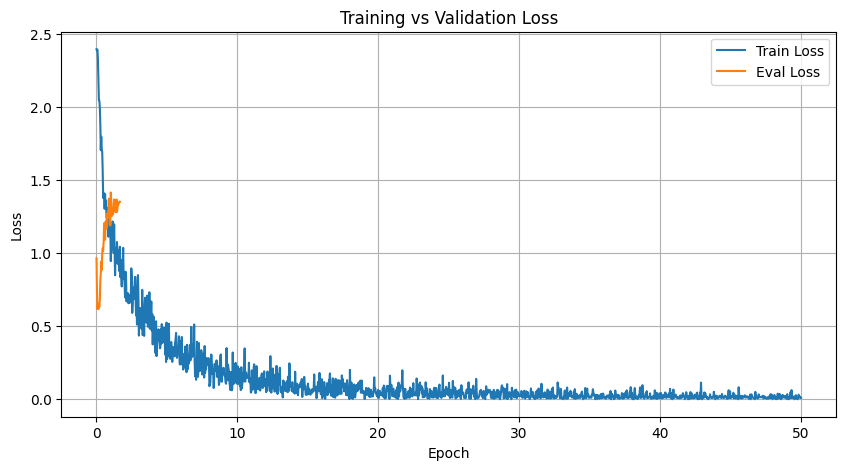

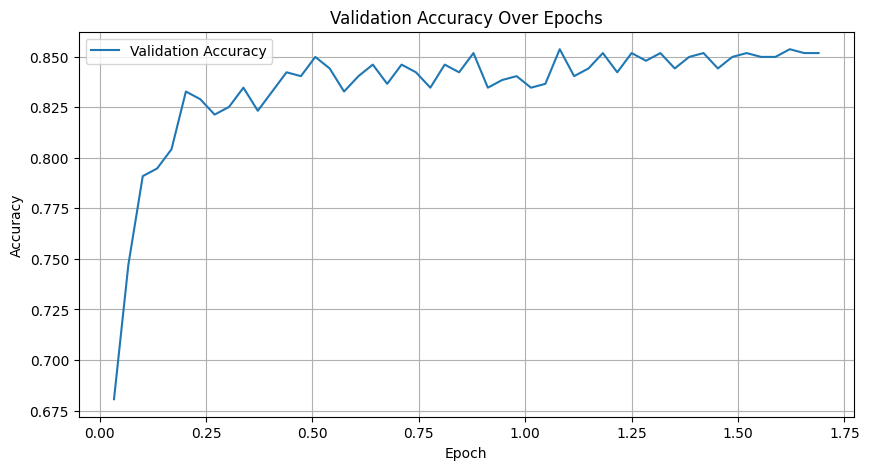

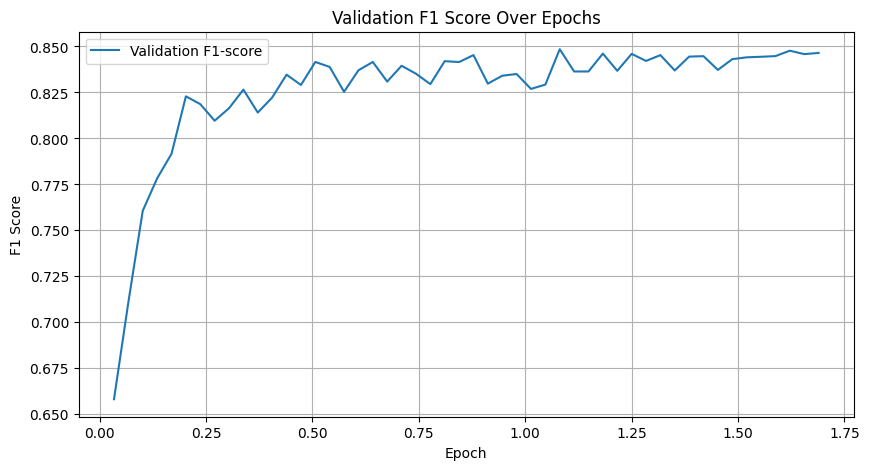

In [ ]:
import matplotlib.pyplot as plt

# Extract log history
log_history = trainer.state.log_history

# Initialize dictionaries to collect metric history
epochs, train_loss, eval_loss = [], [], []
eval_accuracy, eval_f1 = [], []

# Parse logs
for entry in log_history:
    if 'epoch' in entry:
        epoch = entry['epoch']
        if 'loss' in entry:  # training loss
            train_loss.append(entry['loss'])
            epochs.append(epoch)
        if 'eval_loss' in entry:
            eval_loss.append(entry['eval_loss'])
        if 'eval_accuracy' in entry:
            eval_accuracy.append(entry['eval_accuracy'])
        if 'eval_f1' in entry:
            eval_f1.append(entry['eval_f1'])

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(epochs[:len(train_loss)], train_loss, label="Train Loss")
plt.plot(epochs[:len(eval_loss)], eval_loss, label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(epochs[:len(eval_accuracy)], eval_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot F1-Score Curve
plt.figure(figsize=(10, 5))
plt.plot(epochs[:len(eval_f1)], eval_f1, label="Validation F1-score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report

eval_result = trainer.evaluate()
print(eval_result)

# Predict on validation set for full classification report
preds = trainer.predict(val_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)
print(classification_report(y_true, y_pred, target_names=le.classes_))

{'eval_loss': 1.3555908203125, 'eval_accuracy': 0.8536121673003803, 'eval_precision': 0.8531224423072626, 'eval_recall': 0.84759725528103, 'eval_f1': 0.8485050108032925, 'eval_runtime': 0.3644, 'eval_samples_per_second': 1443.47, 'eval_steps_per_second': 90.56, 'epoch': 50.0}
                        precision    recall  f1-score   support

CourtsAndInvestigation       0.92      0.89      0.90        63
               Cricket       0.86      0.76      0.81        41
           CrimeReport       0.94      0.92      0.93        50
      DomesticPolitics       0.86      0.92      0.89        53
              Football       0.76      0.78      0.77        41
 InternationalPolitics       0.89      0.82      0.85        50
          MusicAndArts       0.82      0.71      0.76        45
                 Other       0.89      0.82      0.85        38
      ResearchAndSpace       0.83      0.96      0.89        50
        ScreenAndStage       0.85      0.87      0.86        45
     TechAndInnova

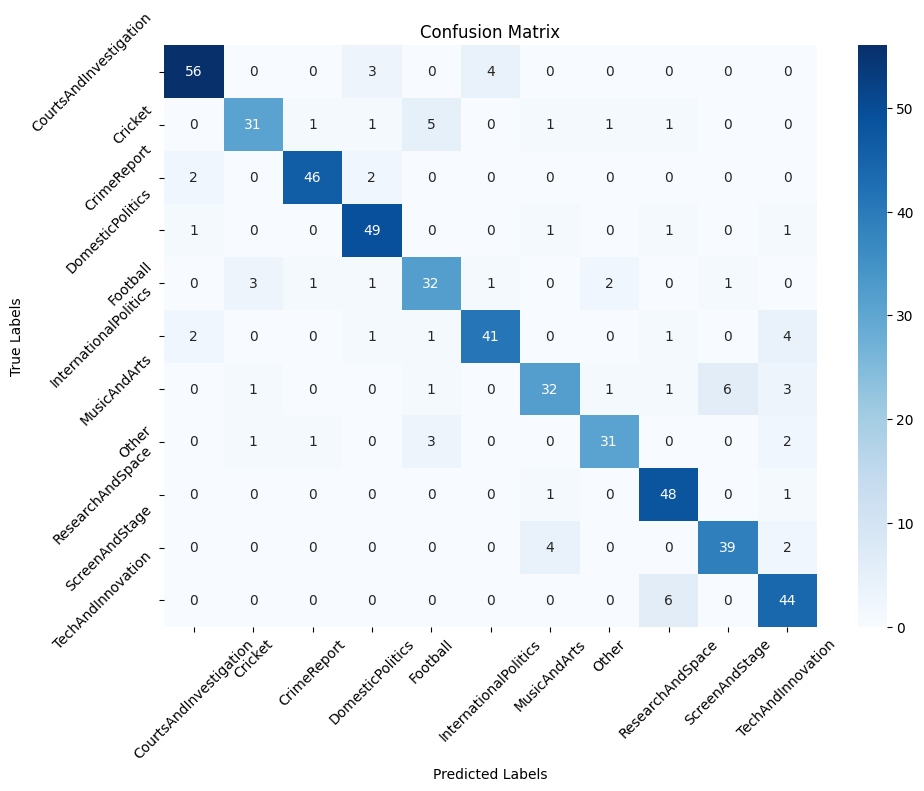

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
trainer.save_model('./fine_tuned_xlm_roberta_news')
tokenizer.save_pretrained('./fine_tuned_xlm_roberta_news')

('./fine_tuned_xlm_roberta_news/tokenizer_config.json',
 './fine_tuned_xlm_roberta_news/special_tokens_map.json',
 './fine_tuned_xlm_roberta_news/sentencepiece.bpe.model',
 './fine_tuned_xlm_roberta_news/added_tokens.json')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "./fine_tuned_xlm_roberta_news"

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
from transformers import TextClassificationPipeline

# Create a pipeline for text classification
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False, device=0)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
text = "ඊශ්‍රායලයෙන් ඉරානයේ ප්‍රදේශ කිහිපයකට ගුවන් ප්‍රහාර"

result = pipeline(text)
print(result)

[{'label': 'LABEL_5', 'score': 0.9998487234115601}]


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Or if you have index:
pred_idx = result[0]['label'].replace("LABEL_", "")  # e.g., "LABEL_2"
label_name = le.inverse_transform([int(pred_idx)])
print(label_name)

['InternationalPolitics']


In [ ]:
from transformers import TextClassificationPipeline

def predict_category(model, tokenizer, text, label_encoder=None, sub_to_main=None, device=-1):
    """
    Predicts subcategory and maps it to a main category (if mapping provided).

    Args:
        model: HuggingFace model.
        tokenizer: Tokenizer.
        text (str): Input text.
        label_encoder (LabelEncoder): For decoding subcategory label index.
        sub_to_main (dict): Mapping from subcategory to main category.
        device (int): 0 for GPU, -1 for CPU.

    Returns:
        tuple: (subcategory, main_category or None)
    """
    pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False, device=device)
    result = pipeline(text)[0]

    if label_encoder is not None:
        if result['label'].startswith("LABEL_"):
            sub_idx = int(result['label'].replace("LABEL_", ""))
        else:
            sub_idx = int(result['label'])
        subcategory = label_encoder.inverse_transform([sub_idx])[0]
    else:
        subcategory = result['label']

    main_category = sub_to_main.get(subcategory, None) if sub_to_main else None
    return subcategory, main_category


In [ ]:
subcategory_to_main = {
    "InternationalPolitics": "PoliticsAndGovernance",
    "DomesticPolitics": "PoliticsAndGovernance",
    "TechAndInnovation": "ScienceAndTechnology",
    "ResearchAndSpace": "ScienceAndTechnology",
    "ScreenAndStage": "CultureAndEntertainment",
    "MusicAndArts": "CultureAndEntertainment",
    "Cricket": "Sports",
    "Football": "Sports",
    "Other": "Sports",
    "CrimeReport": "CrimeAndJustice",
    "CourtsAndInvestigation": "CrimeAndJustice"
}

text = "ඊශ්‍රායලයෙන් ඉරානයේ ප්‍රදේශ කිහිපයකට ගුවන් ප්‍රහාර"

subcategory, main_category = predict_category(
    model, tokenizer, text,
    label_encoder=le,
    sub_to_main=subcategory_to_main
)

print(f"Subcategory: {subcategory}")
print(f"Main Category: {main_category}")

Device set to use cuda:0


Subcategory: InternationalPolitics
Main Category: PoliticsAndGovernance


/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
subcategory,main_category

('InternationalPolitics', 'PoliticsAndGovernance')

In [ ]:
import torch
print(torch.__version__)

2.6.0+cu124
